# Resnet 18 Pytorch
Before training launched two external scripts : dataset_explore.py to check for sure if the data is correct and validation_split.py to create validation data. <br>
I took 15 % of all data ( 1800 images overall ). Script took random images from training data directory with the same distribution of data ( 50%-50%, same as training data).  

In [24]:
# utils 
import numpy as np 

# interacting with os 
import os, sys
import time
import copy

# pytorch dependencies
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch import nn

# Plotting
import matplotlib.pyplot as plt

# Checking if GPU is available
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("using CUDA")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

using CUDA


In [25]:
# copy/paste from ImageFolder class pytorch ( just added to return path argument )
class DatasetWithLabels(datasets.ImageFolder):
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, path

# Structure of Folders

In [26]:
data_dir = '.'
TRAIN = 'Train Images'
VAL = 'Validation Images'
TEST = 'TEST'

def p(label, path):
    print("{} dir path : '{}' : content '{}'".format(label, path, os.listdir(path)))

p("Train", os.path.join(data_dir, TRAIN))
p("Validation", os.path.join(data_dir, VAL))
p("Test", os.path.join(data_dir, TEST))

Train dir path : '.\Train Images' : content '['Large', 'Small', 'valid_lock']'
Validation dir path : '.\Validation Images' : content '['Large', 'Small']'
Test dir path : '.\TEST' : content '['Test Images']'


# dataset loading

In [27]:
# rescale images 
IMG_WIDTH = 360
IMG_HEIGHT = 240

# data transformations ( just rescale and convert to tensor)
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize( (IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
    ]),
    TEST : transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor()
    ])
    
}

# image datasets
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL]
}

dataloaders[TEST] = torch.utils.data.DataLoader( image_datasets[TEST], batch_size=8,shuffle=True, num_workers=4)

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 10198 images under Train Images
Loaded 1800 images under Validation Images
Loaded 7534 images under TEST
Classes: 
['Large', 'Small']


# plot some images

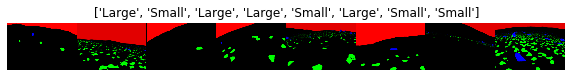

In [28]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

# training the architecture 
Resnet 18 architecure gave best accuracies ( compared to vgg11 and vgg13 with natch normalizations). Classificator Layer is replaced with 2 linear layer, dropout with large value ( 0.5 ), and relu activation ( no activation at the end of classifier, because loss applies softmax value )

In [41]:
model_finetuning = models.resnet18(pretrained=True)

in_features = model_finetuning.fc.in_features # 512 * 7 * 7
x = nn.Sequential(nn.Linear(in_features, 128), 
                   nn.ReLU(),
                   nn.Dropout(0.5), 
                   nn.Linear(128, 2))


model_finetuning.fc = x

model_finetuning = model_finetuning.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model_finetuning.parameters())

# gamma = decaying factor
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.8)

In [42]:
model_finetuning

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
# General function that trains pytorch model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("*"*16)
        
        # each epoch has training and validation phase
        for phase in [TRAIN, VAL]:
            if phase ==TRAIN:
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0.
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward 
                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == TRAIN and scheduler is not None:
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == VAL and epoch_acc >= best_acc:
                print("Swapping {} -> {}".format(best_acc, epoch_acc))
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [44]:
model_ft = train_model(model_finetuning, criterion, optimizer_ft, scheduler=scheduler, num_epochs=10)

Epoch 0/9
****************
Train Images Loss: 0.0918 Acc: 0.9751
Validation Images Loss: 0.0188 Acc: 0.9939
Swapping 0.0 -> 0.9938888888888889
Epoch 1/9
****************
Train Images Loss: 0.0239 Acc: 0.9928
Validation Images Loss: 0.0123 Acc: 0.9967
Swapping 0.9938888888888889 -> 0.9966666666666667
Epoch 2/9
****************
Train Images Loss: 0.0226 Acc: 0.9943
Validation Images Loss: 0.0040 Acc: 0.9989
Swapping 0.9966666666666667 -> 0.9988888888888889
Epoch 3/9
****************
Train Images Loss: 0.0247 Acc: 0.9942
Validation Images Loss: 0.0999 Acc: 0.9789
Epoch 4/9
****************
Train Images Loss: 0.0215 Acc: 0.9941
Validation Images Loss: 0.0038 Acc: 0.9994
Swapping 0.9988888888888889 -> 0.9994444444444445
Epoch 5/9
****************
Train Images Loss: 0.0166 Acc: 0.9947
Validation Images Loss: 0.0085 Acc: 0.9978
Epoch 6/9
****************
Train Images Loss: 0.0082 Acc: 0.9969
Validation Images Loss: 0.0007 Acc: 1.0000
Swapping 0.9994444444444445 -> 1.0
Epoch 7/9
**************

# Create Submission

In [46]:
test = DatasetWithLabels(os.path.join(data_dir, TEST), transform=data_transforms[TEST])
test_dataloader = torch.utils.data.DataLoader( test, batch_size=8,shuffle=False, num_workers=0)

vs= {"1" : "Small", "0" : "Large"}
cnt = 0
curr  = 0
perct = 5

f = open("submission.csv", "w")
f.write("Image_File,Class\n")
for inputs, labels, fns in test_dataloader:
    inputs = inputs.to(device)
    outputs = model_ft(inputs)
    _, pds = torch.max(outputs, 1)
    
    pds = pds.cpu().numpy().reshape(-1, 1)
    fns = np.array([file.split("\\")[-1] for file in fns]).reshape(-1, 1)
    for x, y in np.concatenate([fns, pds], axis=1):
        f.write(x + "," + vs[y] + "\n")
    
    cnt += len(fns)
    if cnt / len(test) * 100 >= curr:
        curr += perct
        print(round(cnt / len(test) * 100), "%")
    
f.close()

0 %
5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
55 %
60 %
65 %
70 %
75 %
80 %
85 %
90 %
95 %
100 %
